# Capstone Three: Preprocessing and Modeling

## Overview

In the last notebook, we clean our data and made sure that it was stationary. We were able to see a clear upward trend of the population over time. To see the last notebook, click [here](https://github.com/anthonyysz/CapstoneThree/blob/master/Notebooks/01%20-%20Capstone%20Three%20-%20Data%20Wrangling%20and%20EDA.ipynb).

## 1. Importing our tools

### 1a. Importing useful packages

In [1]:
#Bringing in pandas and matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 1b. Importing Relevant Data

In [2]:
#Bringing in our clean data from the last notebook. popclean will be population data and gdpclean will be gdp data.
df = pd.read_csv('../data/clean/pop_data.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

df1 = pd.read_csv('../data/clean/gdp_data.csv')
df1 = df1.set_index('date')
df1.index = pd.to_datetime(df1.index)

## 2. Preprocessing our data   

A good place to start would be to split our data up into training and testing data. Let's start with the population data and then the GDP data

In [3]:
#I'm going to make a train and test dataframe for certain models, and an x and y split for others. 
#There are some models I'd like to use all of the data for, and others that I'd prefer to use a train and a test set.
train_pop = df[df.index < pd.to_datetime("2005-11-01", format='%Y-%m-%d')]
test_pop = df[df.index > pd.to_datetime("2005-11-01", format='%Y-%m-%d')]
X_pop = pd.DataFrame(df.index)
X_pop = X_pop.reset_index()
X_pop = X_pop.set_index('date')
X_pop.rename(columns = {'index':'instance'}, inplace = True)
y_pop = pd.Series(df['value'])

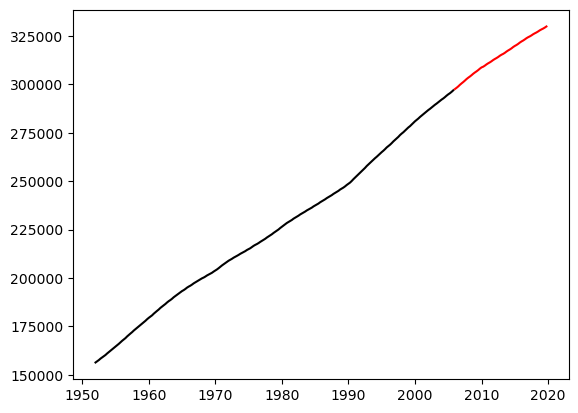

In [4]:
#Plotting train and test data for visual confirmation
plt.plot(train_pop['value'], color = "black")
plt.plot(test_pop['value'], color = "red")
plt.show()

In [5]:
#Repeating train, test, x, y split with the gdp data
train_gdp = df1[df1.index < pd.to_datetime("2005-11-01", format='%Y-%m-%d')]
test_gdp = df1[df1.index > pd.to_datetime("2005-11-01", format='%Y-%m-%d')]
X_gdp = pd.DataFrame(df1.index)
X_gdp = X_gdp.reset_index()
X_gdp = X_gdp.set_index('date')
X_gdp.rename(columns = {'index':'instance'}, inplace = True)
y_gdp = pd.Series(df1['value'])

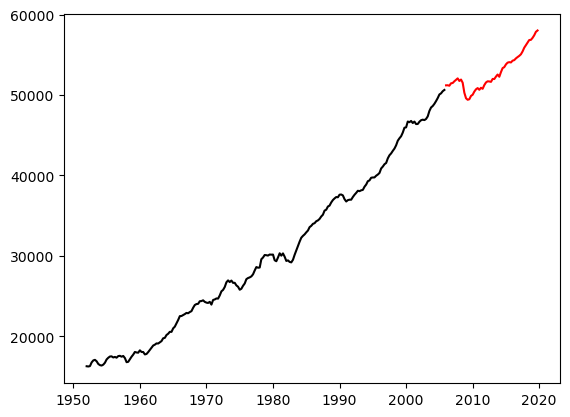

In [6]:
#plotting for visual confirmation
plt.plot(train_gdp['value'], color = "black")
plt.plot(test_gdp['value'], color = "red")
plt.show()

Now, we will use all data from before November of 2005 as our training data, and all data on and since then as our testing data.

## 3. Modeling

### 3a. ARIMA Model

For the ARIMA model, I need to find 3 values for my order: p being the number of autoregressive terms, d being the number of nonseasonal differences needed for stationarity, and q being the number of lagged forecast errors in the prediction equation. I will start with the population data by finding the d value.

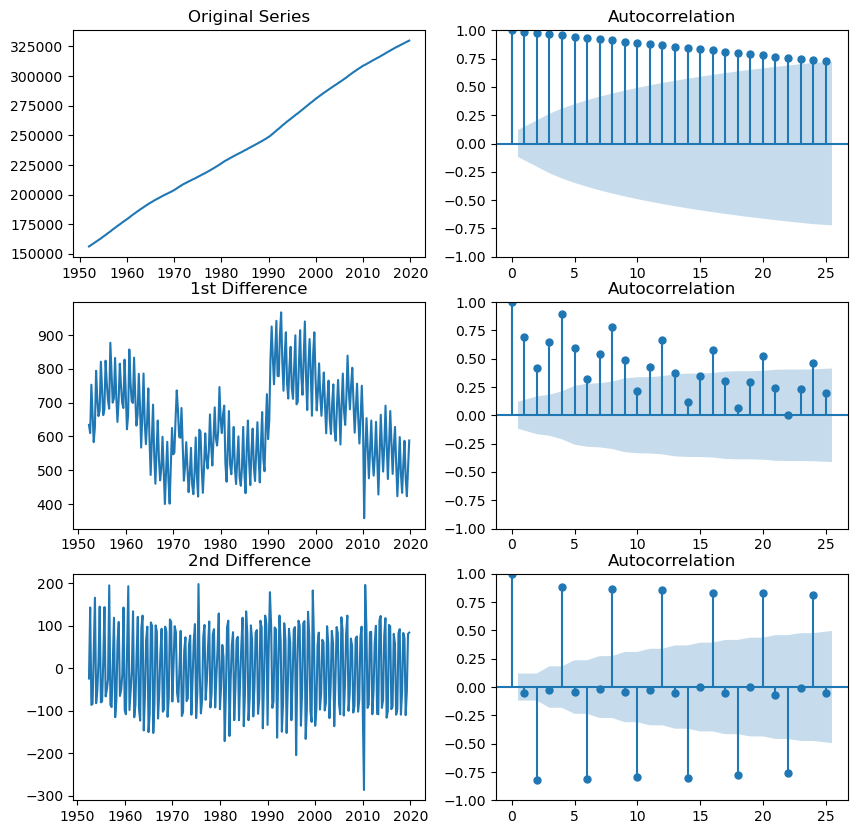

In [7]:
#Plotting the data as well as the acf at when it had been differenced 0, 1, and 2 times.
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(3,2, figsize = (10,10))

a = ax[0,0].plot(df['value']); ax[0,0].set_title('Original Series')
b = plot_acf(df['value'].values,ax=ax[0,1])

c = ax[1,0].plot(df['value'].diff()); ax[1,0].set_title('1st Difference')
d = plot_acf(df['value'].diff().dropna(),ax=ax[1,1])

e = ax[2,0].plot(df['value'].diff().diff()); ax[2,0].set_title('2nd Difference')
f = plot_acf(df['value'].diff().diff().dropna(),ax=ax[2,1])

Right now, I am in between 1 and 2 for the d value. I am going to create a function to find the aic and bic given a dataframe and d value, that way I can determine which will d value will yield the best results.

In [8]:
#Defining function to record the aic and bic for an ARIMA model of certain p and q values, given a d value.
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
def aic_bic(df, d):
    """
    df: dataframe that will be used to find the aic and bic of an ARIMA model given different p and q values
    d: d value in the order of the arima model
    """
    order_aic_bic=[]
    for p in range(5):
        for q in range(5):
            model = ARIMA(df['value'], order=(p, d, q))
            results = model.fit()
            order_aic_bic.append((p, q,results.aic, results.bic))
    order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

    print(order_df.sort_values('AIC'))
    print(order_df.sort_values('BIC'))

In [9]:
#Calling aic_bic function from line 8 given population data differenced once
aic_bic(df, 1)

    p  q          AIC          BIC
24  4  4  2898.832670  2931.251740
23  4  3  2913.645559  2942.462510
19  3  4  2918.198308  2947.015259
18  3  3  2931.003027  2956.217858
22  4  2  2938.897434  2964.112266
21  4  1  2981.441278  3003.053991
20  4  0  3011.806656  3029.817250
17  3  2  3013.745128  3035.357841
16  3  1  3072.700473  3090.711068
15  3  0  3174.312258  3188.720733
14  2  4  3186.617059  3211.831891
8   1  3  3204.393963  3222.404558
9   1  4  3213.131818  3234.744531
12  2  2  3214.084901  3232.095495
7   1  2  3218.732483  3233.140958
13  2  3  3219.939835  3241.552548
11  2  1  3253.401937  3267.810413
6   1  1  3261.381658  3272.188015
10  2  0  3755.188643  3765.995000
5   1  0  3841.176677  3848.380914
3   0  3  4220.087300  4234.495776
4   0  4  4234.504697  4252.515291
2   0  2  4254.992590  4265.798946
1   0  1  4266.468037  4273.672275
0   0  0  4284.001160  4287.603279
    p  q          AIC          BIC
24  4  4  2898.832670  2931.251740
23  4  3  2913.64555

In [10]:
#Calling aic_bic function from line 8 given population data differenced twice
aic_bic(df, 2)

    p  q          AIC          BIC
24  4  4  2710.256275  2742.642073
19  3  4  2711.185469  2739.972845
23  4  3  2724.024190  2752.811565
22  4  2  2726.542498  2751.731452
17  3  2  2728.488297  2750.078829
18  3  3  2732.686396  2757.875349
13  2  3  2745.071878  2766.662410
14  2  4  2749.541029  2774.729982
12  2  2  2765.356038  2783.348147
20  4  0  2809.074369  2827.066479
21  4  1  2809.305255  2830.895787
16  3  1  2867.433190  2885.425300
15  3  0  2917.496710  2931.890398
11  2  1  2956.380060  2970.773747
10  2  0  2977.143976  2987.939242
4   0  4  3029.862777  3047.854886
9   1  4  3031.795886  3053.386418
8   1  3  3103.280266  3121.272376
2   0  2  3124.030989  3134.826255
7   1  2  3125.926413  3140.320101
3   0  3  3126.422126  3140.815813
6   1  1  3197.305009  3208.100275
1   0  1  3229.878181  3237.075025
0   0  0  3242.923598  3246.522020
5   1  0  3244.672023  3251.868867
    p  q          AIC          BIC
19  3  4  2711.185469  2739.972845
24  4  4  2710.25627

We got much lower AIC and BIC values using a d value of 2, so our model will be created using the order (3, 2, 4).

In [11]:
#Creating function to create an ARIMA model with a different starttime due to differences.
#Function will print a summary of the model, as well as return the fitted model and the predictions,
import datetime
def arima_model(df, order):
    """
    df: dataframe used to train the model
    order: tuple of three numbers that will be used to create the ARIMA model (p, d, q)
    """
    model = ARIMA(df['value'], order=order)
    modelfit = model.fit()
    predictions = modelfit.predict(start = df.index[order[1]])
    print(modelfit.summary())
    return modelfit, predictions

In [12]:
#Calling arima_model function from line 11 for the population data
model1, predictions1 = arima_model(df, (3,2,4))

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  272
Model:                 ARIMA(3, 2, 4)   Log Likelihood               -1347.593
Date:                Sun, 04 Dec 2022   AIC                           2711.185
Time:                        19:42:42   BIC                           2739.973
Sample:                    01-01-1952   HQIC                          2722.745
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9585      0.038    -24.979      0.000      -1.034      -0.883
ar.L2         -0.9972      0.005   -200.337      0.000      -1.007      -0.987
ar.L3         -0.9492      0.039    -24.283      0.0

Here, since the Ljung-Box p value is above .05, the null hypothesis is not rejected and we cannot say for sure that the residuals are uncorrelated. Additionally, however, we also reject the Heteroskedasticity null hypothesis, which means that the residuals in the prediction don't show variance over time. I am going to plot the predicted data over the actual data, this way we can see how they compare to each other visually.

In [13]:
#Defining function to plot a comparison of the recorded data and the data predicted by our arima model
from sklearn.metrics import mean_squared_error
def arima_comparison(df, predictions):
    """
    df: dataframe used for the relevant ARIMA model
    predictions: predictions returned from the same ARIMA model
    """
    predictions.plot(label = 'Predicted Data')
    df['value'].plot(label = 'Recorded Data')
    plt.legend()
    plt.show()

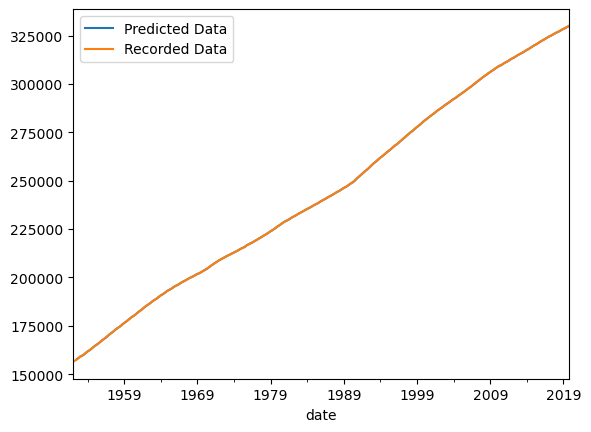

In [14]:
#Calling arima_comparison function from line 13
arima_comparison(df, predictions1)

In [15]:
#Finding RMSE of ARIMA model given population data
arima_gdp_rmse = np.sqrt(mean_squared_error(df['value'].values[2:], predictions1))
print("RMSE: ",arima_gdp_rmse)

RMSE:  35.97506756655676


The ARIMA model of the population data has a root mean squared error of 35.98. We will use the model with the lowest root mean squared error as our best model in the end. Let's do the same with our GDP per capita data.

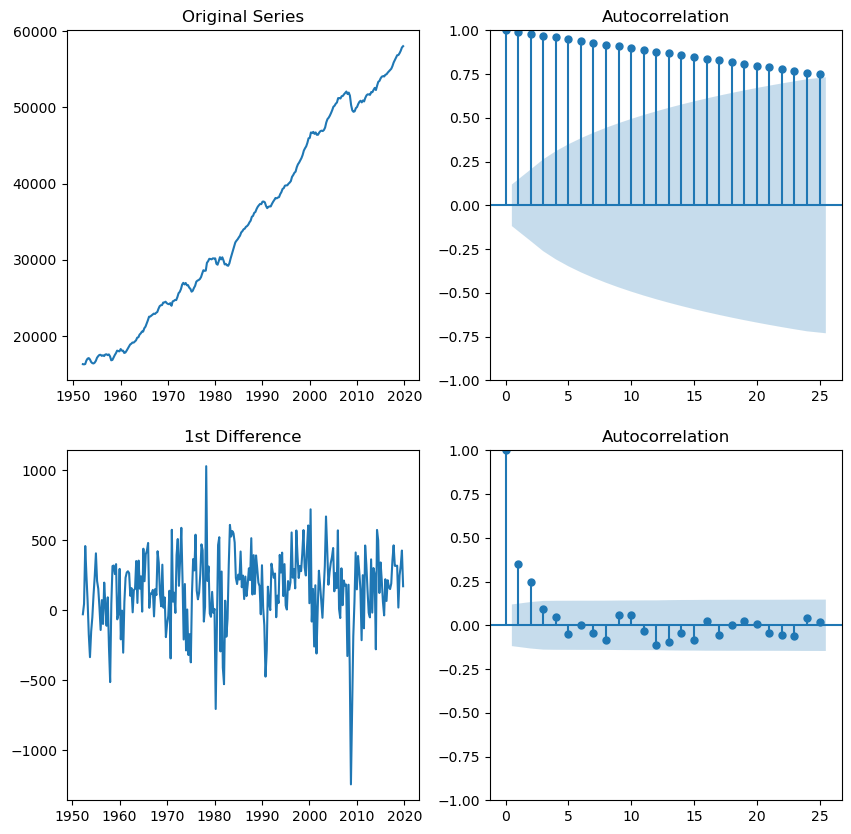

In [16]:
#Plotting the data as well as the acf at when it had been differenced 0 and 1 times
fig,ax = plt.subplots(2,2, figsize = (10,10))

a = ax[0,0].plot(df1['value']); ax[0,0].set_title('Original Series')
b = plot_acf(df1['value'].values,ax=ax[0,1])

c = ax[1,0].plot(df1['value'].diff()); ax[1,0].set_title('1st Difference')
d = plot_acf(df1['value'].diff().dropna(),ax=ax[1,1])

Here, we unquestionably reach stationarity after differencing once, so our d value will be 1. Let's use the same aic_bic function as we did before to find the best p and q values for our order.

In [17]:
#Calling aic_bic function from line 8 given gdp data differenced once
aic_bic(df1, 1)

    p  q          AIC          BIC
16  3  1  3762.594007  3780.604601
13  2  3  3764.653329  3786.266042
17  3  2  3764.931784  3786.544497
9   1  4  3765.177777  3786.790490
8   1  3  3765.744457  3783.755051
11  2  1  3766.060068  3780.468543
22  4  2  3767.317120  3792.531952
14  2  4  3769.653790  3794.868622
23  4  3  3769.681496  3798.498446
18  3  3  3774.598720  3799.813552
19  3  4  3775.957482  3804.774432
6   1  1  3776.884713  3787.691070
24  4  4  3778.594069  3811.013138
7   1  2  3778.807333  3793.215808
10  2  0  3779.283972  3790.090329
12  2  2  3779.912748  3797.923342
15  3  0  3780.081117  3794.489592
20  4  0  3780.977330  3798.987924
21  4  1  3782.601544  3804.214257
4   0  4  3786.667711  3804.678305
3   0  3  3791.829295  3806.237771
5   1  0  3792.784772  3799.989010
2   0  2  3799.816567  3810.622923
1   0  1  3821.701375  3828.905612
0   0  0  3869.129349  3872.731468
    p  q          AIC          BIC
11  2  1  3766.060068  3780.468543
16  3  1  3762.59400

I'm going to go with the lower aic and create my ARIMA model for the GDP per capita data with an order of (3, 1, 1).

In [18]:
#Calling arima_model function from line 11 for gdp data
model2, predictions2 = arima_model(df1, (3, 1, 1))

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  272
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1876.297
Date:                Sun, 04 Dec 2022   AIC                           3762.594
Time:                        19:42:48   BIC                           3780.605
Sample:                    01-01-1952   HQIC                          3769.825
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2768      0.047     27.283      0.000       1.185       1.369
ar.L2         -0.1391      0.085     -1.632      0.103      -0.306       0.028
ar.L3         -0.1378      0.058     -2.390      0.0

Here, once again, we reject the null hypothesis for both the Ljung-Box test and the Heteroskedasticity test. We once again cannot say for sure that the residuals are uncorrelated and can say that the residuals in the prediction do not show variance over time. I'm going to again use my plot_comparison function to see what the data looks like layed on top of one another.

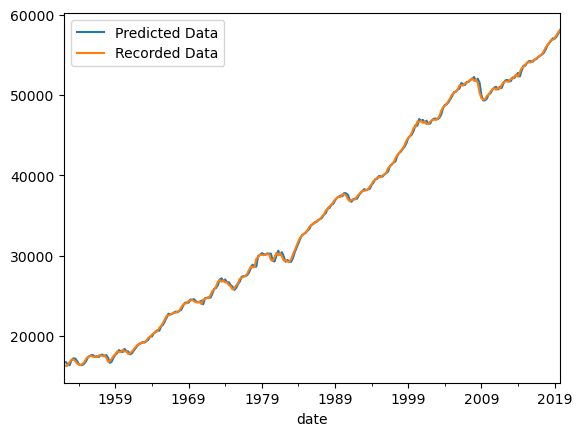

In [19]:
#Calling arima_comparison function from line 13
arima_comparison(df1, predictions2)

We can see that predicted data is not quite right on top of the recorded data so much as it was with the population data. We are likely going to see a slightly larger RMSE for these predictions.

In [20]:
#Finding RMSE of ARIMA model given gdp data
arma_gdp_rmse = np.sqrt(mean_squared_error(df1['value'].values[1:], predictions2))
print("RMSE: ",arma_gdp_rmse)

RMSE:  245.92276675321546


For the GDP per capita ARIMA model, we see a root mean squared error more than triple that of the ARIMA model for the population data. When looking at the graphs however, the former looks way further off. This is because the GDP per capita data is anywhere from ~20000 to ~60000, whereas the population data runs upwards of 300,000 where the predictions are being made. In order to have a model for the GDP per capita data as accurate as the ARIMA model for the population data, we would expect an RMSE of close to 6 of 7. While that might be out of the picture for an RMSE to be that low, it is notable to compare the 2 in that way so that we can properly understand what we are seeing from RMSE.

### 3b. Linear Regression

The next type of model I would like to try is sklearn's linear regression model. The population data is very linear, so we might find this somewhat useful in that regard. I don't have high hopes for the GDP per capita data, but it's worth a shot.

In [21]:
#Defining a function that will compare the linear regression model to the actual data, and print the rmse of the model
from sklearn.linear_model import LinearRegression
def linreg_comparison(X, y):
    """    
    X: Dataframe with date as the index and a count of the instance as a column
    y: Series with the data and the value
    """
    model = LinearRegression()
    modelfit = model.fit(X, y)
    y_pred = pd.Series(modelfit.predict(X), index=X.index)
    y.plot()
    y_pred.plot()
    plt.legend()
    plt.show()
    linreg_rmse = np.sqrt(mean_squared_error(y, y_pred))
    print("RMSE: ",linreg_rmse)
    return modelfit

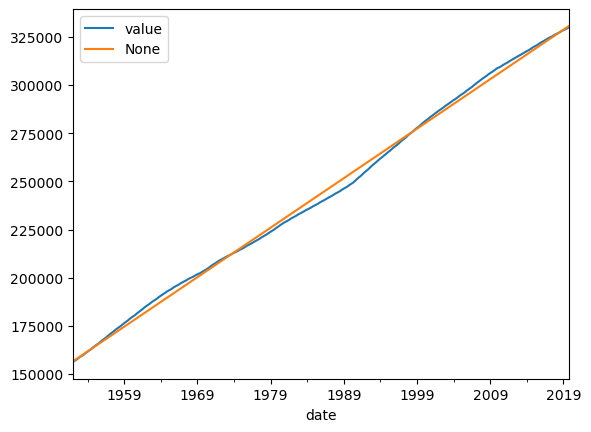

RMSE:  2500.036122667604


In [22]:
#Calling linreg_comparison function from line 21 for population data
model3 = linreg_comparison(X_pop, y_pop)

With a RMSE of just over 2500, the linear regression model is not going to be viable for making predictions on the population. Let's try the same with the GDP per capita data.

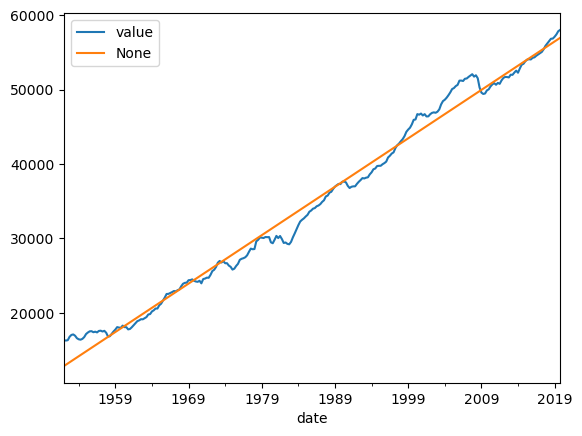

RMSE:  1439.2368394053824


In [23]:
#Calling linreg_comparison function from line 21 for gdp data
model4 = linreg_comparison(X_gdp, y_gdp)

Once again, the RMSE is outlandishly high, so we can say pretty confidently that we will not be using the linear regression model to make predictions on either of these datasets.

### 3c. SVR Regression

In [24]:
from sklearn.svm import LinearSVR
def svr_comparison(X, y):
    """    
    X: Dataframe with date as the index and a count of the instance as a column
    y: Series with the data and the value
    """
    model = LinearSVR()
    modelfit = model.fit(X, y)
    y_pred = pd.Series(modelfit.predict(X), index=X.index)
    y.plot()
    y_pred.plot()
    plt.legend()
    plt.show()
    linreg_rmse = np.sqrt(mean_squared_error(y, y_pred))
    print("RMSE: ",linreg_rmse)
    return modelfit

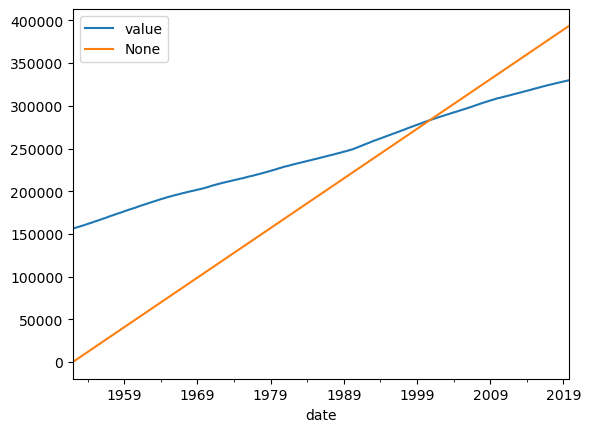

RMSE:  78975.6389051618


In [25]:
model5 = svr_comparison(X_pop, y_pop)

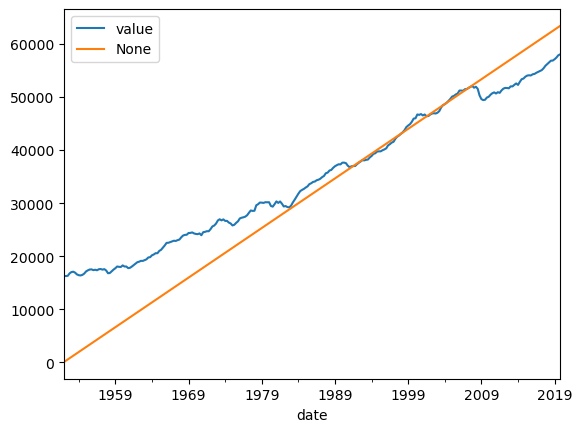

RMSE:  6555.019393163065


In [26]:
model6 = svr_comparison(X_gdp, y_gdp)

### 3d. XGBoost

In [48]:
import xgboost as xbg
def xgb_comparison(X, y):
    """    
    X: Dataframe with date as the index and a count of the instance as a column
    y: Series with the data and the value
    """
    model = xbg.XGBRegressor()
    modelfit = model.fit(X, y)
    y_pred = pd.Series(modelfit.predict(X), index=X.index)
    y.plot(label = 'Recorded Data')
    y_pred.plot(label = 'Predicted Data')
    plt.legend()
    plt.show()
    linreg_rmse = np.sqrt(mean_squared_error(y, y_pred))
    print("RMSE: ",linreg_rmse)
    return modelfit

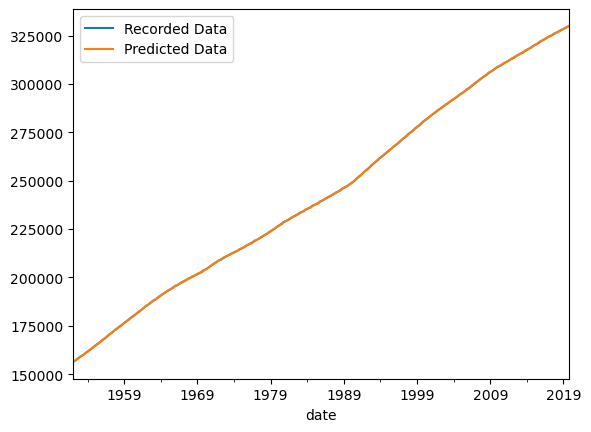

RMSE:  114.54217252391813


In [49]:
model7 = xgb_comparison(X_pop, y_pop)

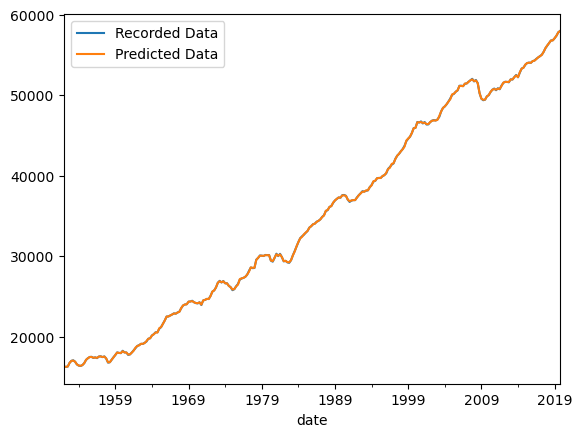

RMSE:  33.38916685271288


In [50]:
model8 = xgb_comparison(X_gdp, y_gdp)

## 4. Choosing our best models

In [30]:
def arima_predictions(model, df):
    y_pred = model.get_forecast(40)
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_out = y_pred_df["Predictions"] 
    plt.plot(y_pred_out, color='red', label = 'ARIMA Predictions')
    plt.plot(df['value'], label = 'Recorded Data')
    plt.legend()
    plt.show()
    return pd.DataFrame(y_pred_df.index)

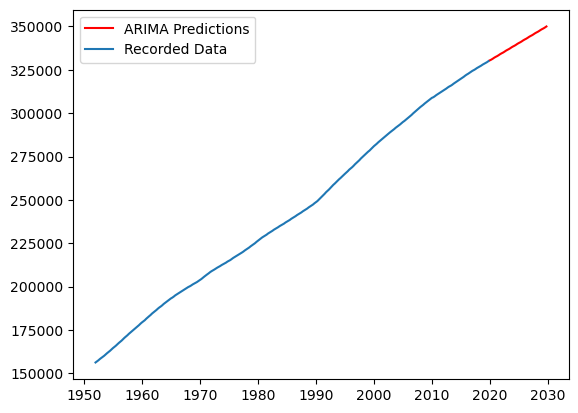

In [31]:
future_dates = arima_predictions(model1, df)